<a href="https://colab.research.google.com/github/KulwinderSingh07/AI-Lab/blob/master/Data_Project_Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'signature-verification-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107946%2F262177%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T080947Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9deeae1091a4d918f8e1967724f4d230882353165dbef770fefa265560432e2551206b2359167ac01f0901ec9c9dbe81cc0acc88d6c4921fe58d84950ffa8bcaebf895610cd39f2a10c090ce49ec78b28f3904c03c6e63946254b2c1ac817074d5aa1855fdf9cea2a177235a6b06cf0e2209b9360c0ad407fa45ac9a8fc1a054dffe4d864e45a6981386ff8b32dcd3e45cc61115b6aca54089c9939acd8e9213477e74a9083e79718fc2b8b451afa09e72dd97f065672920f0f86b53a1f7021f7b6c8d7b1218c334c8f990303b3ef40a0386baf9dc4fba72e84414ee747874b257f2618ce851c81a2f9008744262ac3652edbc2e8184aed7d82e67b9c893cd86'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 629730434 bytes downloaded
Downloaded and uncompressed: signature-verification-dataset
Data source import complete.


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import pickle
import datetime
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, \
    Dropout, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.utils import to_categorical
from sklearn.utils import shuffle

In [9]:
# ==========================================================
# define functions
# ==========================================================
def read_data(dir, data):
    images1 = []  # the real one
    images2 = []  # the forged one

    labels = []
    for j in range(0, len(data)):
        path = os.path.join(dir, data.iat[j, 0])
        img1 = cv2.imread(path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img1 = cv2.resize(img1, (100, 100))
        images1.append([img1])

        path = os.path.join(dir, data.iat[j, 1])
        img2 = cv2.imread(path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        img2 = cv2.resize(img2, (100, 100))
        images2.append([img2])

        labels.append(np.array(data.iat[j, 2]))

    images1 = np.array(
        images1).astype(np.float32) / 255.0
    images2 = np.array(images2).astype(np.float32) / 255.0
    labels = np.array(labels).astype(np.float32)
    return images1, images2, labels

def build_base_network(input_shape):
    seq = Sequential()

    kernel_size = 3
    seq.add(Convolution2D(32, (kernel_size, kernel_size), input_shape=input_shape))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Convolution2D(64, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Convolution2D(128, (kernel_size, kernel_size)))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))

    seq.add(Flatten())
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(128, activation='relu'))
    return seq
#
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [4]:
# ==========================================================
# data reading and preparation
# ==========================================================
train_dir = '../input/signature-verification-dataset/sign_data/train/'
train_csv = '../input/signature-verification-dataset/sign_data/train_data.csv'
test_dir = '../input/signature-verification-dataset/sign_data/test/'
test_csv = '../input/signature-verification-dataset/sign_data/test_data.csv'

#
df_train = pd.read_csv(train_csv, header=None)
df_train.head()

#
df_test = pd.read_csv(test_csv, header=None)
df_test.head()

#
test_images1, test_images2, test_labels = read_data(dir=test_dir, data=df_test)
train_images1, train_images2, train_labels = read_data(dir=train_dir, data=df_train)

#
# train_labels = to_categorical(train_labels)

#
train_images1, train_images2, train_labels = shuffle(train_images1, train_images2, train_labels)
test_images1, test_images2, test_labels = shuffle(test_images1, test_images2, test_labels)

#
size = 100
train_images1 = train_images1.reshape(-1, size, size, 1)
train_images2 = train_images2.reshape(-1, size, size, 1)
test_images1 = test_images1.reshape(-1, size, size, 1)
test_images2 = test_images2.reshape(-1, size, size, 1)

In [5]:
print(df_train.iloc[0, :])
img_org = df_train.iloc[0, 0]
img_frg = df_train.iloc[0, 1]

0             068/09_068.png
1    068_forg/03_0113068.PNG
2                          1
Name: 0, dtype: object


../input/signature-verification-dataset/sign_data/train/068/09_068.png


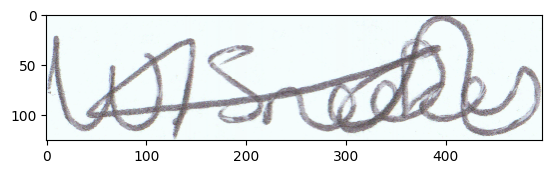

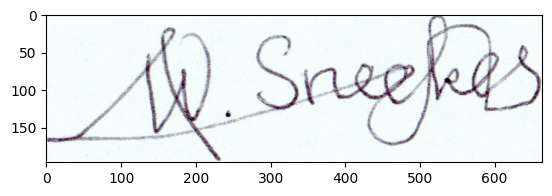

In [6]:
img_original = plt.imread('../input/signature-verification-dataset/sign_data/train/'+img_org)
img_forged = plt.imread('../input/signature-verification-dataset/sign_data/train/'+img_frg)

print('../input/signature-verification-dataset/sign_data/train/'+img_org)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_original)

plt.subplots(1, 1, sharex=True, sharey=True)
plt.imshow(img_forged)

In [10]:
#
input_dim = (100, 100, 1)

#
base_network = build_base_network(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

prediction = Dense(1, activation='sigmoid')(distance)


model = Model([img_a, img_b], prediction)
model.summary()

earlyStopping_callback = EarlyStopping(monitor='val_accuracy',
                                       min_delta=0.01,  # Set a value based on your needs
                                       patience=5,
                                       verbose=1,
                                       mode='max',
                                       restore_best_weights=True)

# Callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir)

model_checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)

callback_early_stop_reduceLROnPlateau = [earlyStopping_callback, tensorboard_callback, model_checkpoint_callback]

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100, 100, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128)                  3402624   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['sequential[0][0]',      

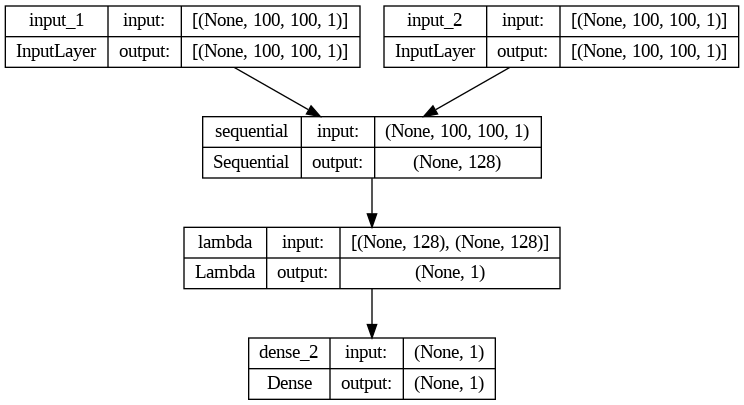

In [11]:
#
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
#
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(lr=0.00008)
              , metrics=["accuracy"])

#
history = model.fit([train_images1, train_images2], train_labels, validation_split=.30,
                    batch_size=32, verbose=1, epochs=10, callbacks=callback_early_stop_reduceLROnPlateau)

Epoch 1/10
508/508 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.8047
Epoch 1: val_loss improved from inf to 0.30424, saving model to best_model.h5
508/508 [==============================] - 23s 30ms/step - loss: 0.4184 - accuracy: 0.8047 - val_loss: 0.3042 - val_accuracy: 0.9839
Epoch 2/10
  4/508 [..............................] - ETA: 9s - loss: 0.3045 - accuracy: 0.9922 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


507/508 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.9863
Epoch 2: val_loss improved from 0.30424 to 0.21539, saving model to best_model.h5
508/508 [==============================] - 13s 25ms/step - loss: 0.2638 - accuracy: 0.9863 - val_loss: 0.2154 - val_accuracy: 0.9951
Epoch 3/10
508/508 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9958
Epoch 3: val_loss improved from 0.21539 to 0.15787, saving model to best_model.h5
508/508 [==============================] - 11s 22ms/step - loss: 0.1912 - accuracy: 0.9958 - val_loss: 0.1579 - val_accuracy: 0.9958
Epoch 4/10
508/508 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9996
Epoch 4: val_loss improved from 0.15787 to 0.11504, saving model to best_model.h5
508/508 [==============================] - 11s 22ms/step - loss: 0.1359 - accuracy: 0.9996 - val_loss: 0.1150 - val_accuracy: 0.9996
Epoch 5/10
508/508 [==============================] - ETA: 0s - loss: 0.0993 -

Here is a screenshot of how TensorBoard looks like in our problem:

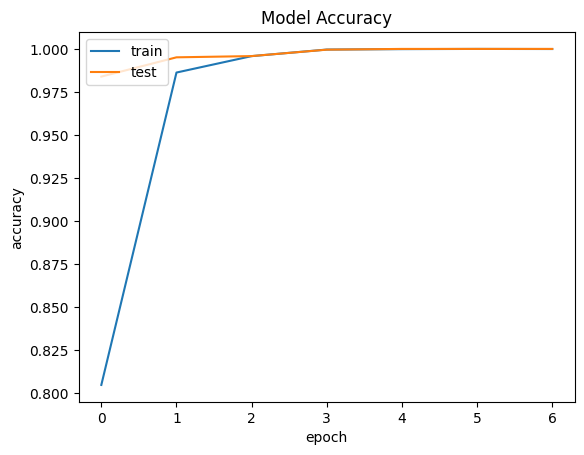

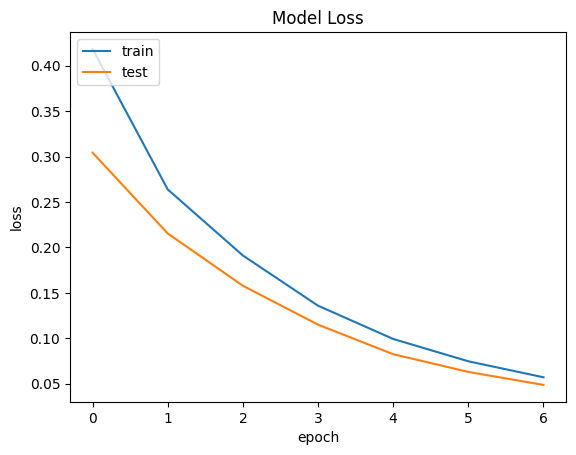

In [13]:
#Plot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

# Plot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [18]:
from tensorflow.keras.models import load_model
model.save('final_model.keras')

# If you want to save the best model based on validation loss
best_model = load_model('/kaggle/working/best_model.h5')

In [15]:
def predict_distance(model, img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Resize the images to match the model's expected input shape
    img1 = cv2.resize(img1, (100, 100))
    img2 = cv2.resize(img2, (100, 100))

    img1 = np.expand_dims(img1, axis=-1)
    img2 = np.expand_dims(img2, axis=-1)

    img1 = np.expand_dims(img1, axis=0)  # Add batch dimension
    img2 = np.expand_dims(img2, axis=0)  # Add batch dimension

    output = model.predict([img1, img2])
#     print(output)

    euclidean_distance = np.linalg.norm(output)

    return euclidean_distance

# model = load_model("model.h5")  # Assuming you have saved your TensorFlow model

# test_data_dir = "/path/to/test/data/directory"
# test_csv_path = "/path/to/test/csv/file"

def checkImages(img1_path,img2_path,label):
    eucledian_distance = predict_distance(model, img1_path, img2_path)
    print("Predicted Eucledian Distance:-", eucledian_distance)
    if eucledian_distance>=0.8:
        print("Model Predicts signature being forged")
    else:
        print("Model Predicts signatures being valid")
    print("Actual Label:-", label)

test_df = pd.read_csv(test_csv)

for i in range(20):
    img1_path = os.path.join(test_dir, test_df.iloc[i, 0])
    img2_path = os.path.join(test_dir, test_df.iloc[i, 1])
#     print(img1_path)
#     print(img2_path)
    checkImages(img1_path,img2_path,"Forged Signature Pair")

img1_path="/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png"
img2_path="/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png"



img1_path="/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png"
img2_path="/kaggle/input/signature-verification-dataset/sign_data/test/049/01_049.png"

checkImages(img1_path,img2_path,"Original Pair of Signature")

img1_path="../input/signature-verification-dataset/sign_data/test/068/09_068.png"
img2_path="../input/signature-verification-dataset/sign_data/test/068_forg/01_0124068.PNG"
checkImages(img1_path,img2_path,"Forged Signature Pair")

1/1 [==============================] - 0s 433ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [==============================] - 0s 18ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [==============================] - 0s 17ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [==============================] - 0s 18ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [==============================] - 0s 18ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [==============================] - 0s 20ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair
1/1 [======================

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
# model.save('final_model.h5')

# If you want to save the best model based on validation loss
best_model = load_model('/kaggle/working/final_model.h5')

1/1 [==============================] - 0s 19ms/step
Predicted Eucledian Distance:- 1.0
Model Predicts signature being forged
Actual Label:- Forged Signature Pair


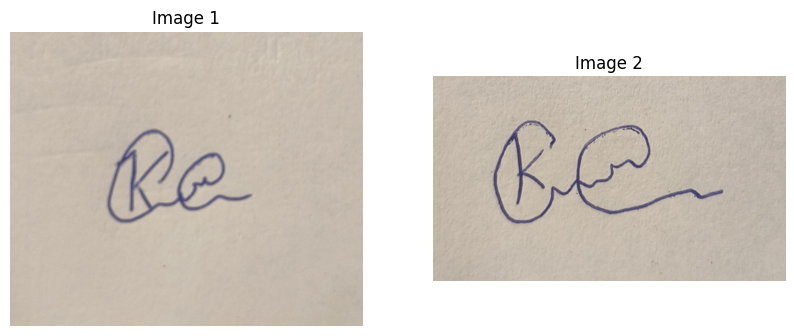

1/1 [==============================] - 0s 20ms/step
Predicted Eucledian Distance:- 0.28449708
Model Predicts signatures being valid
Actual Label:- Original Pair of Signature


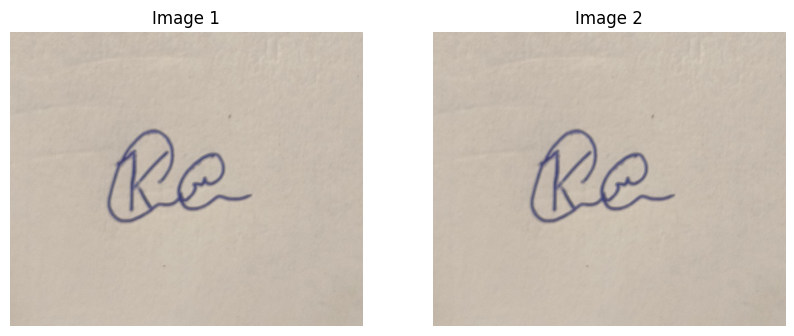

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_distance(model, img1_path, img2_path):
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    # Resize the images to match the model's expected input shape
    img1 = cv2.resize(img1, (100, 100))
    img2 = cv2.resize(img2, (100, 100))

    img1 = np.expand_dims(img1, axis=-1)
    img2 = np.expand_dims(img2, axis=-1)

    img1 = np.expand_dims(img1, axis=0)  # Add batch dimension
    img2 = np.expand_dims(img2, axis=0)  # Add batch dimension

    output = model.predict([img1, img2])
#     print(output)

    euclidean_distance = np.linalg.norm(output)

    return euclidean_distance

# model = load_model("model.h5")  # Assuming you have saved your TensorFlow model

# test_data_dir = "/path/to/test/data/directory"
# test_csv_path = "/path/to/test/csv/file"

def checkImages(img1_path,img2_path,label):
    eucledian_distance = predict_distance(model, img1_path, img2_path)
    print("Predicted Eucledian Distance:-", eucledian_distance)
    if eucledian_distance>=0.8:
        print("Model Predicts signature being forged")
    else:
        print("Model Predicts signatures being valid")
    print("Actual Label:-", label)

test_df = pd.read_csv(test_csv)

# for i in range(20):
#     img1_path = os.path.join(test_dir, test_df.iloc[i, 0])
#     img2_path = os.path.join(test_dir, test_df.iloc[i, 1])
# #     print(img1_path)
# #     print(img2_path)
#     checkImages(img1_path,img2_path,"Forged Signature Pair")


def printImage(img1_path,img2_path):
  # Load the images
  img1 = mpimg.imread(img1_path)
  img2 = mpimg.imread(img2_path)

  # Create a figure with two subplots
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

  # Display the images
  ax1.imshow(img1)
  ax1.set_title('Image 1')
  ax1.axis('off')

  ax2.imshow(img2)
  ax2.set_title('Image 2')
  ax2.axis('off')

  plt.show()

img1_path="real_personel.jpeg"
img2_path="forge_personel.jpeg"
# img2_path="/content/real_personel.jpeg"
checkImages(img1_path,img2_path,"Forged Signature Pair")
printImage(img1_path,img2_path)




img2_path="real_personel.jpeg"
# img2_path="forge_personel.jpeg"
checkImages(img1_path,img2_path,"Original Pair of Signature")
printImage(img1_path,img2_path)